In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

# Part 1 - Prepare SQLAlchemy 

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)
conn = engine.connect()

In [23]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)
measurement_df = pd.read_sql('select * from measurement', conn)
measurement_df.head()

id      station        date  prcp  tobs
0   1  USC00519397  2010-01-01  0.08  65.0
1   2  USC00519397  2010-01-02  0.00  63.0
2   3  USC00519397  2010-01-03  0.00  74.0
3   4  USC00519397  2010-01-04  0.00  76.0
4   5  USC00519397  2010-01-06   NaN  73.0

In [25]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)
station_df = pd.read_sql('select * from station', conn)
station_df.head()

id      station                                    name  latitude  \
0   1  USC00519397                    WAIKIKI 717.2, HI US   21.2716   
1   2  USC00513117                    KANEOHE 838.1, HI US   21.4234   
2   3  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US   21.5213   
3   4  USC00517948                       PEARL CITY, HI US   21.3934   
4   5  USC00518838              UPPER WAHIAWA 874.3, HI US   21.4992   

   longitude  elevation  
0  -157.8168        3.0  
1  -157.8015       14.6  
2  -157.8374        7.0  
3  -157.9751       11.9  
4  -158.0111      306.6

# Part 2 - Exploratory Climate Analysis

#### Precipitation Analysis

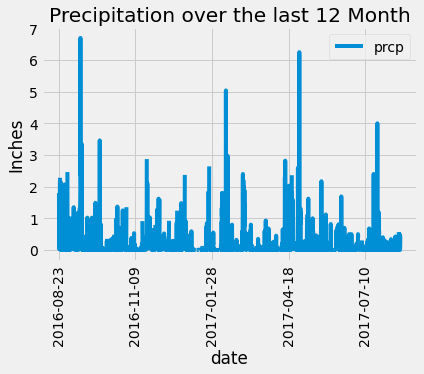

In [155]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column

query = '''
    select date, prcp 
    from measurement 
    where date >= (select date(max(date), '-1 year') from measurement)

'''

measurement = pd.read_sql(query, conn)
measurement_df = measurement.set_index('date')

# Sort the dataframe by date
prcp_data = measurement_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
plot = prcp_data.plot(title = 'Precipitation over the last 12 Month')
plot.set_ylabel('Inches')
plt.xticks(rotation=90)

fig = plot.get_figure()
# fig.savefig("Precipitation.png")

#### Station Analysis

In [73]:
# Design a query to calcuate the total number of stations
total_station = pd.read_sql('select count(station) from station', conn)
total_station

count(station)
0               9

In [156]:
# List the stations and observation counts in descending order.
query = '''
select 
       name, 
       count(station) as active_count 
from measurement 
join station 
using (station) 
group by name
order by count(station) desc
'''

active_station = pd.read_sql(query, conn)
active_station

name  active_count
0                     WAIHEE 837.5, HI US          2772
1                    WAIKIKI 717.2, HI US          2724
2                    KANEOHE 838.1, HI US          2709
3      WAIMANALO EXPERIMENTAL FARM, HI US          2669
4            MANOA LYON ARBO 785.2, HI US          2612
5  KUALOA RANCH HEADQUARTERS 886.9, HI US          2202
6       HONOLULU OBSERVATORY 702.2, HI US          1979
7                       PEARL CITY, HI US          1372
8              UPPER WAHIAWA 874.3, HI US           511

In [173]:
# Which station has the highest number of observations?
station_names = active_station['name']
most_active_station = station_names.iloc[0]
most_active_station

'WAIHEE 837.5, HI US'

In [179]:
query = f'''
select 
    min(tobs) as min_temp,
	avg(tobs) as avg_temp,
	max(tobs)as max_temp
from measurement
join station
using (station)
where name = '{most_active_station}'
'''

temp_obs_df = pd.read_sql(query, conn)
temp_obs_df

min_temp   avg_temp  max_temp
0      54.0  71.663781      85.0

In [182]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
query = f'''
select 
   tobs
from measurement
join station
using (station)
where 
   date >= (select date(max(date), '-1 year') from measurement)
   and name = '{most_active_station}'
'''

tobs_df = pd.read_sql(query, conn)
tobs_df

tobs
0    77.0
1    77.0
2    80.0
3    80.0
4    75.0
..    ...
347  77.0
348  77.0
349  76.0
350  76.0
351  79.0

[352 rows x 1 columns]

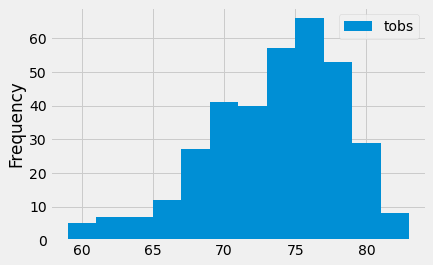

In [185]:
tobs_df.plot.hist(bins=12)

## Part 2 - Climate App (Design a Flask API)

In [149]:
import flask
from flask import Flask, jsonify
import json

In [150]:
app = Flask(__name__)

In [151]:
@app.route('/')
def home():
    return(
        f"Welcome to the Hawaii Climate App API!<br/>"
        f"Available Rountes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/apit/v1.0/<start>/<end><br/>"
    )

In [152]:
@app.route('/api/v1.0/precipitation')
def precipitation():
    data_prcp_json = prcp_data.to_json(orient='records')
    return(data_prcp_json)

In [153]:
@app.route('/api/v1.0/stations')
def stations():
    data_station_json = station.to_json(orient='records')
    return(data_station_json)

In [154]:
@app.route('/api/v1.0/tobs')
def tobs():
    data_tobs_json = tobs.to_json(orient='records')
    return(data_tobs_json)


## Part 3 - Data Analysis Assignment

### Temperature Analysis 1 - June/Dec Comparison

In [202]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.
query = '''
select 
    tobs as june_temp
from station
join measurement
using (station)
where date like '%-06-%'
'''
june_temp = pd.read_sql(query, conn)
june_temp.head()

june_temp
0       78.0
1       76.0
2       78.0
3       76.0
4       77.0

In [203]:
query = '''
select 
    tobs as dec_temp
from station
join measurement
using (station)
where date like '%-12-%'
'''
dec_temp = pd.read_sql(query, conn)
dec_temp.head()

dec_temp
0      76.0
1      74.0
2      74.0
3      64.0
4      64.0

In [201]:
# calcuate the t-test
from scipy import stats

t_result = stats.ttest_ind(june_temp, dec_temp)

alpha = 0.05

if (t_result[1] < alpha):
    print("A and B are different!")

A and B are different!


### Temperature Analysis II

In [205]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    query = f'''
    select 
        min(tobs) as min_temp,
        avg(tobs) as avg_temp,
        max(tobs)as max_temp
    from measurement
    join station
    using (station)
    where date between '{start_date}' and '{end_date}'
    '''
    temp_stats_df = pd.read_sql(query, conn)
    temp_stats = tuple(temp_stats_df.values[0])
    
    return temp_stats

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.57142857142857, 74.0)


In [206]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# (select date(max(date), '-1 year')
def calc_temps_last_year(start_date, end_date):
    
    query = f'''
    select 
        min(tobs) as min_temp,
        avg(tobs) as avg_temp,
        max(tobs)as max_temp
    from measurement
    join station
    using (station)
    where date between date('{start_date}', '-1 year') and date('{end_date}', '-1 year')
    '''
    temp_stats_df = pd.read_sql(query, conn)
    temp_stats = tuple(temp_stats_df.values[0])
    
    return temp_stats

# function usage example
print(calc_temps('2014-02-28', '2015-03-05'))

(56.0, 73.1635602890833, 85.0)


In [215]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
start_date = '2018-07-05'
end_date = '2018-07-31'
query = f'''
    select 
        min(tobs) as min_temp,
        avg(tobs) as avg_temp,
        max(tobs)as max_temp
    from measurement
    join station
    using (station)
    where date between date('{start_date}', '-1 year') and date('{end_date}', '-1 year')
    '''
temp_stats_df = pd.read_sql(query, conn)
temp_stats_df

min_temp  avg_temp  max_temp
0      69.0  78.45977      84.0

In [247]:
# create variables
min_temp = temp_stats_df.iloc[0,0]
max_temp = temp_stats_df.iloc[0,1]
avg_temp = temp_stats_df['avg_temp']

avg_temp

0    78.45977
Name: avg_temp, dtype: float64

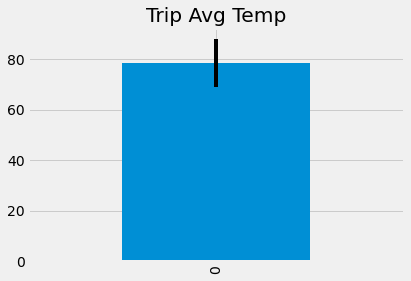

In [249]:
# plot error bar chart
import numpy as np
import matplotlib.pyplot as plt

peak_to_peak = max_temp - min_temp

avg_temp.plot(kind='bar', yerr= peak_to_peak, title = 'Trip Avg Temp')

### Daily Rainfall Average

In [253]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2018-07-05'
end_date = '2018-07-31'

query = '''
select 
	station,
	sum(prcp) as total_prcp
from station
join measurement
using (station)
group by station
order by total_prcp DESC
'''

total_rainfall = pd.read_sql(query, conn)
total_rainfall

station  total_prcp
0  USC00516128     1068.09
1  USC00519281      588.64
2  USC00513117      382.62
3  USC00519523      295.68
4  USC00514830      234.49
5  USC00519397      131.62
6  USC00511918       92.68
7  USC00518838       70.87
8  USC00517948       43.44

In [263]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):

    query = f'''
    select 
	station,
	min(tobs) as min_temp,
	max(tobs) as max_temp,
	avg(tobs) as avg_temp
    from station
    join measurement
    using (station)
    where date like '{date}'
    '''
    
    daily_normal = pd.read_sql(query, conn)
    
    return daily_normal
    
daily_normals("%3-%11")

station  min_temp  max_temp   avg_temp
0  USC00519523      60.0      82.0  72.166667

In [289]:
# Create a list of dates for your trip in the format %m-%d. 
# Use the daily_normals function to calculate the normals for each date string and append the results to a list.
dates = ['%06-%23', '%07-%06', '%12-%23']
min_temp_list = []
max_temp_list = []
avg_temp_list = []
for date in dates:
    query = f'''
    select 
	min(tobs) as min_temp,
	max(tobs) as max_temp,
	avg(tobs) as avg_temp
    from station
    join measurement
    using (station)
    where date like '{date}'
    ''' 
    daily_normal = pd.read_sql(query, conn)
    min_temp = daily_normal.iloc[0,0]
    max_temp = daily_normal.iloc[0,1]
    avg_temp = daily_normal.iloc[0,2]
    
    min_temp_list.append(min_temp)
    max_temp_list.append(max_temp)
    avg_temp_list.append(avg_temp)
        
min_temp_list
max_temp_list
avg_temp_list

[74.54385964912281, 75.0, 71.65891472868218]

In [318]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Plot the daily normals as an area plot with `stacked=False`
min_temp_list_df = pd.DataFrame(min_temp_list)
#min_temp_list_df = min_temp_list.rename(columns={0:'min'}, inplace=True)

max_temp_list_df = pd.DataFrame(max_temp_list)
#max_temp_list_df = max_temp_list.rename(columns={0:'max'}, inplace=True)

avg_temp_list_df = pd.DataFrame(avg_temp_list)
#avg_temp_list_df = avg_temp_list.rename(columns={0:'avg'}, inplace=True)

daily_normal = pd.concat([min_temp_list_df, max_temp_list_df, avg_temp_list_df], axis=1)
daily_normal

#df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)

min   max        avg
0  68.0  80.0  74.543860
1  69.0  81.0  75.000000
2  61.0  80.0  71.658915

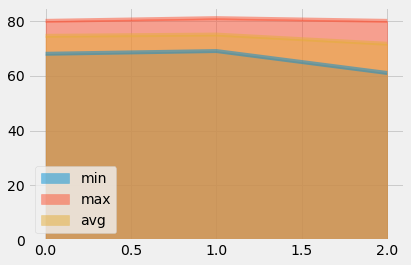

In [329]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_normal.plot.area(stacked=False)
